In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def linear_equation(x, m, b):
    return (m*x) + b

def find_resistance(current_data, voltage_data):
    # R = V/I
    popt, pcov = curve_fit(linear_equation, current_data, voltage_data)
    resistance, intercept = popt
    resistance_sigma, intercept_sigma = np.sqrt(np.diag(pcov))
    return resistance, intercept, resistance_sigma

def plot_resistance(csv_file, B, R, Magnet=True):
    resistance_data = pd.read_csv(f'{csv_file}', skiprows=8, index_col=0)
    current = resistance_data.iloc[:,13]
    voltage = resistance_data.iloc[:,0]

    resistance, intercept, resistance_sigma = find_resistance(current, voltage)
    
    if Magnet:
        plt.scatter(current, voltage, label=f"Magnet")
        plt.title(f'Resistance ({B} to {R} run 2 - Magnet)')
    else:
        plt.scatter(current, voltage,label = f"No Magnet" )
        plt.title(f'Resistance ({B} to {R} run 1 - No Magnet)')
        
    # Plot line of best fit
    y_fit = linear_equation(current, resistance, intercept)
    plt.plot(current, y_fit, color='red', label='Best fit line')

    plt.xlabel('Current (A)')
    plt.ylabel('Voltage')
    plt.legend(title=f'Resistance = {resistance:.3f} ohms +/- {resistance_sigma:.3f} ohms')

    plt.show()

    return resistance, resistance_sigma

def find_hall_resistance(magnet_csv, no_magnet_csv, B, R):
    magnet_data = pd.read_csv(f'{magnet_csv}', skiprows=8, index_col=0)
    magnet_current = magnet_data.iloc[:,13]
    magnet_voltage = magnet_data.iloc[:,0]

    no_magnet_data = pd.read_csv(f'{no_magnet_csv}', skiprows=8, index_col=0)
    no_magnet_current = no_magnet_data.iloc[:,13]
    no_magnet_voltage = no_magnet_data.iloc[:,0]

    difference_voltage = magnet_voltage - no_magnet_voltage

    resistance, intercept, resistance_sigma = find_resistance(magnet_current, difference_voltage)
    y_fit = linear_equation(resistance, magnet_current, intercept)

    plt.scatter(magnet_current, magnet_voltage, label="Magnet")
    plt.scatter(no_magnet_current, no_magnet_voltage, label="No Magnet")
    plt.scatter(magnet_current, difference_voltage, label="Hall Effect")

    # Plot line of best fit
    plt.plot(magnet_current, y_fit, color='red', label='Best fit line')
    plt.xlabel('Current (A)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.title(f'Resistances ({B} to {R})')

    plt.show()

    print(f'Hall resistance = {resistance:.3f} ohms +/- {resistance_sigma:.3f} ohms')

    return resistance, resistance_sigma

# Calculating Resistance
In order to calculate the resistance of our silicon wafer, we must first plot the voltage and the current measured across it before finding the slope of that plot. As resistance, R, can be found using Ohm's law:
$$V = IR \to R = \frac{V}{I}$$

Subtract no magnetic field plot from magnetic field plot to get true hall resistance across QB and RC

Zeroed tesla meter with magnetic sheild cavity. Magnetic field strength ($\overset{\rightharpoonup}{B}$) measured as $\approx$ 0.09 $\pm$ 0.003 T

1 T = 10,000 Gauss

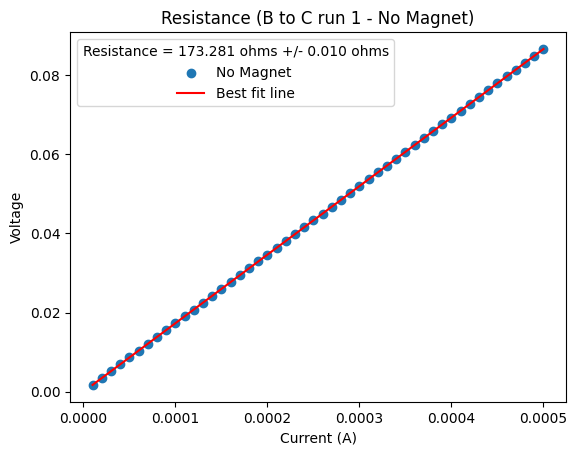

In [43]:
Rbc, Rbc_sigma = plot_resistance('Data/BbRcRun1.csv', 'B', 'C', Magnet=False)

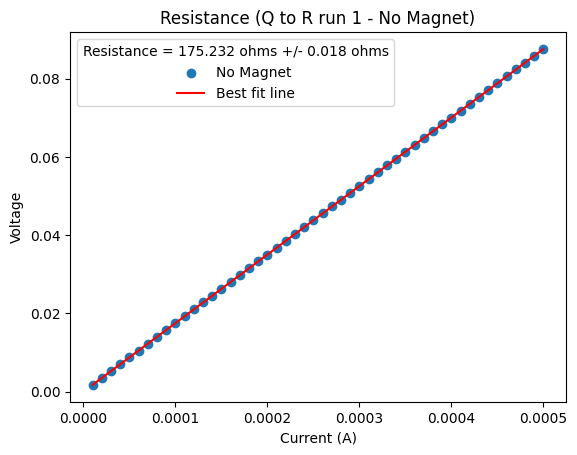

In [44]:
Rqr, Rqr_sigma = plot_resistance('Data/BqRrRUN2.csv', 'Q', 'R', Magnet=False)

Now, we can find the average resistance found across the wafer using these plots, along with the average uncertainty.

In [45]:
avg_R = (Rbc + Rqr)/2
avg_R_sigma = ((Rbc_sigma + Rqr_sigma)/2)
print(f'Average resistance = {avg_R:.3f} ohms +/- {avg_R_sigma:.3f} ohms')

Average resistance = 174.256 ohms +/- 0.014 ohms


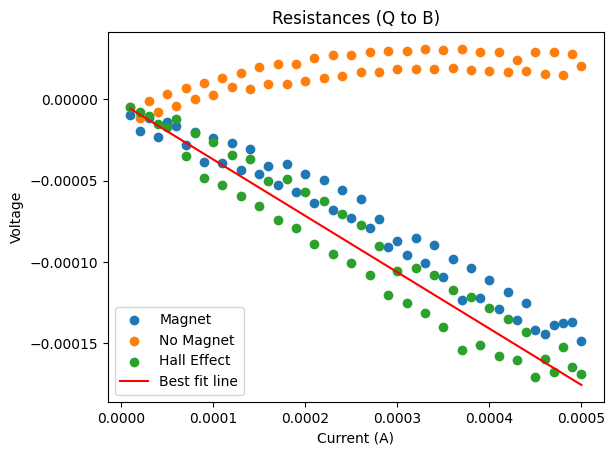

Hall resistance = -0.346 ohms +/- 0.012 ohms


In [46]:
RHqb, RHqb_sigma = find_hall_resistance('Data/BqRbRUN3.csv', 'Data/BqRbRUN10.csv', 'Q', 'B')

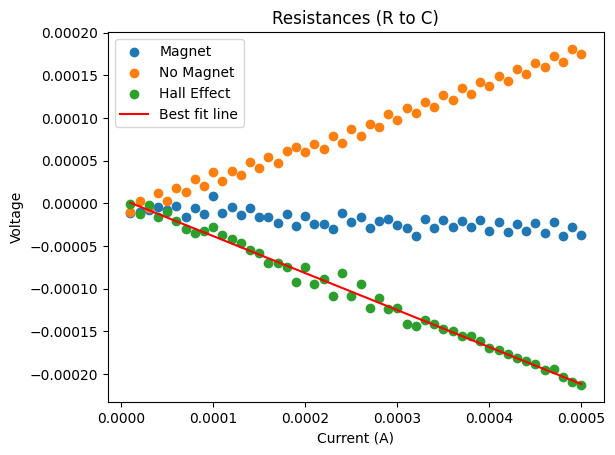

Hall resistance = -0.434 ohms +/- 0.006 ohms


In [47]:
RHrc, RHrc_sigma = find_hall_resistance('Data/BrRcRUN5.csv', 'Data/BrRcRUN8.csv', 'R', 'C')

In [48]:
avg_RH = (RHqb + RHrc)/2
avg_RH_sigma = (RHrc_sigma + RHqb_sigma)/2
print(f'Average Hall resistance = {avg_RH:.3f} +/- {avg_RH_sigma:.3f}')

Average Hall resistance = -0.390 +/- 0.009


We can now find the average resistivity by calculating the area and length of the wafer and using the formula:
$$\rho = \frac{A R}{l}$$
Where A is the area and l is the length and $\rho$ is the resistivity in $\Omega \cdot m$ (ohm meters).

In [54]:
def calc_rho_from_R(avg_R, avg_R_sigma):
    # State R +/- R_sigma & R
    R1 = avg_R - avg_R_sigma
    R2 = avg_R
    R3 = avg_R + avg_R_sigma

    # Dimensions of wafer
    h = 5e-6 # m
    w = 0.008 # m
    l = 0.002 # m
    a = h*w

    # Finding rho ranges
    rho1 = a * R1 / l
    rho2 = a * R2 / l
    rho3 = a * R3 / l

    rho = rho2
    rho_sigma = rho3-rho1

    return rho, rho_sigma

rho, rho_sigma = calc_rho_from_R(avg_R, avg_R_sigma)
print(f'Resistivity = {rho:.8f} (Ohm meters) +/- {rho_sigma:.8f} (Ohm meters)')

Resistivity = 0.00348513 (Ohm meters) +/- 0.00000055 (Ohm meters)
